In [80]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle

In [81]:
# results_df = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10. ELECSIM/run/beis_case_study/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-19_12-50-23-capacity_52152.csv')
results_df = pd.read_csv('/Users/b1017579/Documents/PhD/Projects/10. ELECSIM/run/beis_case_study/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-29_10-36-40-capacity_52152.csv')

results_df

Unnamed: 0  contributed_CCGT  contributed_Coal  contributed_Onshore  \
0             0         349443.18         198018.24         23300.555309   
1             1         258126.78         168618.39         23464.752699   
2             2         335294.40         213202.83         21601.843042   
3             3         397751.70         180192.68         23278.203832   
4             4         152841.90         134111.19         22125.504788   
5             5         379246.32         199495.54         23464.752699   
6             6         158029.44         134657.08         24587.126216   
7             7         203259.84         128186.19         31262.008003   
8             8         330830.52         219754.40         23020.557437   
9             9         242432.40         190931.00         23182.781702   
10           10         308474.94         237114.71         21342.258238   
11           11         352843.50         216872.30         22998.474553   
12           12         123807.84         159973.08         21843.533790   
13           13         335562.78         243417.38         23182.781702   
14           14         161715.06         129946.04         24261.156950   
15           15         207777.90         122899.37         30848.817346   
16           16         256958.28         158593.32         20129.913738   
17           17         168546.42         123834.31         19645.737792   
18           18         275060.40         188759.51         20487.390098   
19           19         255858.06         170913.65         20988.770353   
20           20         123082.56          80169.44         17465.130931   
21           21         283186.56         163752.20         21399.256155   
22           22         103665.60         102255.77         19265.371236   
23           23         120609.30         111176.74         20131.083888   
24           24         273735.60         134386.94         20084.406382   
25           25         203944.50          90959.36         19563.424999   
26           26         271548.96         190587.87         20440.427354   
27           27         241535.04         184043.48         20941.840201   
28           28         146038.32          55298.52         17424.647593   
29           29         243888.54         202031.49         21351.846823   
..          ...               ...               ...                  ...   
114         114         509184.06              0.00        106993.328737   
115         115         953166.06              0.00        114962.149076   
116         116         213325.42              0.00        102860.560007   
117         117         556249.54              0.00        108284.190759   
118         118         150404.10              0.00         99770.687814   
119         119         210314.72              0.00         98388.553642   
120         120          38808.00              0.00         94809.072640   
121         121              0.00              0.00         96398.647443   
122         122          20984.04              0.00         93824.325487   
123         123          55440.00              0.00        100381.122074   
124         124              0.00              0.00         84231.082902   
125         125          18480.00              0.00         99175.483815   
126         126              0.00              0.00         84442.289771   
127         127              0.00              0.00         89530.522042   
128         128              0.00              0.00         93133.932886   
129         129              0.00              0.00         94937.045177   
130         130              0.00              0.00         92247.283628   
131         131              0.00              0.00         98671.465830   
132         132              0.00              0.00         83435.320646   
133         133              0.00              0.00         97605.903225   
134         134              0.00              0.00  

In [82]:
def get_mix(df):
    df['actual_perc'] = df['value_actual'] / df['value_actual'].sum()
    df['simulated_perc'] = df['value_predicted'] / df['value_predicted'].sum()
    return df


def get_projection_difference_sum(results_df, year_to_compare=None):
    ROOT_DIR = '/Users/b1017579/Documents/PhD/Projects/10. ELECSIM/run'
    
    contributed_results = results_df.filter(regex='contributed_')  # .tail(MARKET_TIME_SPLICES)
    contributed_results *= 1 / 24

    # best_mix_year = contributed_results.apply(get_year)
    best_mix_year = contributed_results.copy()
    # best_mix_year['year'] = np.repeat(list(range(YEARS_TO_RUN)), 8)
    best_mix_year['year'] = np.repeat(list(range(int(len(best_mix_year.index)/8))), 8)
    # print("contributed_results: {}".format(contributed_results))
    best_mix_year = best_mix_year.rename(columns={'contributed_PV': "contributed_solar"})
    cluster_size = pd.Series([22.0, 30.0, 32.0, 35.0, 43.0, 53.0, 68.0, 82.0])
    # contributed_results['cluster_size'] = [22.0, 30.0, 32.0, 35.0, 43.0, 53.0, 68.0, 82.0]
    # print("best_mix_year: {}".format(best_mix_year))
    results_wa = best_mix_year.groupby('year').apply(
        lambda x: np.average(x, weights=cluster_size.values, axis=0)).to_frame()
    # print("results_wa: {}".format(results_wa))
    results_wa_split = pd.DataFrame(results_wa)
    # print(results_wa.values)
    results_wa_split[
        ['ccgt', "coal", 'onshore', 'offshore', 'solar', 'nuclear', 'recip_gas', 'biomass', 'year']] = pd.DataFrame(
        results_wa[0].values.tolist(), index=results_wa.index)
    results_wa_split
    # print("results_wa_split: {}".format(results_wa_split))
    # results_wa.index = results_wa.index.str.split("_").str[1].str.lower()
    # print("results_wa: {}".format(results_wa))
    # offshore = results_wa.loc["offshore"].iloc[0]
    # onshore = results_wa.loc["onshore"].iloc[0]
    results_wa_split['wind'] = results_wa_split['offshore'] + results_wa_split['onshore']
    results_wa_split['Natural_gas'] = results_wa_split['ccgt'] + results_wa_split['recip_gas']
    results_wa_split['Renewables'] = results_wa_split['biomass'] + results_wa_split['wind'] + results_wa_split['solar']
    results_wa_split = results_wa_split.drop(['offshore', 'onshore', 'ccgt', 'recip_gas', 'biomass', 'wind', 'solar'],
                                             axis=1)
    results_wa_split = results_wa_split.drop([0, 'year'], axis=1)
    results_wa_long = pd.melt(results_wa_split.reset_index(), id_vars="year")
    results_wa_long['year'] += 2018
    # print("results_wa_long: {}".format(results_wa_long))

    if year_to_compare is not None:
        # results_wa_long = results_wa_long[results_wa_long.year == year_to_compare+1]
        results_wa_long = results_wa_long[results_wa_long.year == year_to_compare]

    results_wa_long = results_wa_long.rename(columns={'variable': "fuel_type"})
    results_wa_long = results_wa_long.set_index(['year', 'fuel_type'])
    # results_wa = results_wa.append(pd.DataFrame({"wind", offshore+onshore}))
    # results_wa.loc['wind'] = [offshore+onshore]
    # print("results_wa: {}".format(results_wa))
    beis_forecast = pd.read_csv('{}/../run/beis_case_study/data/reference_run/2018-2035-beis.csv'.format(ROOT_DIR))
    # electricity_mix = pd.read_csv("{}/data/processed/electricity_mix/energy_mix_historical.csv".format(ROOT_DIR))
    beis_forecast['fuel_type'] = beis_forecast['fuel_type'].replace(
        {"Coal": 'coal', 'Natural gas': 'Natural_gas', "Nuclear": "nuclear"})
    beis_2035_long = pd.melt(beis_forecast, id_vars='fuel_type')
    # print("beis_2035_long: {}".format(beis_2035_long))
    beis_2035_long.variable = pd.to_numeric(beis_2035_long.variable)
    # beis_2035_long = beis_2035_long[beis_2035_long.variable <= 2020]
    beis_2035_long = beis_2035_long.rename(columns={"variable": "year"})
    # print("beis_2035_long_1 : {}".format(beis_2035_long))
    beis_2035_long = beis_2035_long.set_index(["year", 'fuel_type'])
    # print("beis_2035_long: {}".format(beis_2035_long))
    # print("results_wa_long: {}".format(results_wa_long))
    joined = beis_2035_long.join(results_wa_long, how='inner', lsuffix="_actual", rsuffix="_predicted")
    # print("joined: \n{}".format(joined))
    joined = joined.rename(columns={'value': 'actual', 0: 'simulated'})
    # joined = joined.reset_index()
    # joined = joined.loc[~joined.index.str.contains('biomass')]
    # print("joined: \n{}".format(joined))
    joined = joined.groupby("year").apply(get_mix)
    return joined

In [83]:
per_year_dat = get_projection_difference_sum(results_df)
per_year_dat.head()

value_actual  value_predicted  actual_perc  simulated_perc
year fuel_type                                                              
2019 Natural_gas           106     10159.206320     0.360544        0.383771
2034 coal                    0         0.000000     0.000000        0.000000
2029 Renewables            180     51102.199743     0.557276        0.756335
2024 Natural_gas            75      6703.148021     0.273723        0.101411
2019 coal                    2      7355.567427     0.006803        0.277862

In [84]:
per_year_long = per_year_dat.drop(['value_actual', 'value_predicted'], axis=1).reset_index().melt(['year','fuel_type'])
per_year_long.head()

year    fuel_type     variable     value
0  2019  Natural_gas  actual_perc  0.360544
1  2034         coal  actual_perc  0.000000
2  2029   Renewables  actual_perc  0.557276
3  2024  Natural_gas  actual_perc  0.273723
4  2019         coal  actual_perc  0.006803

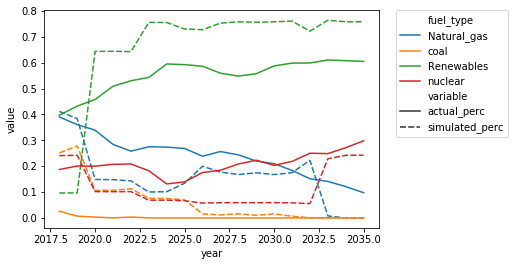

In [85]:
sns.lineplot(data=per_year_long, x='year', hue='fuel_type', style='variable', y='value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim([2020,2032])

# Plot all of the runs

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-41-52-capacity_52152.csv


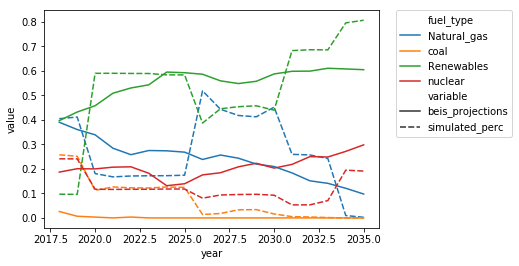

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_21-21-35-capacity_52152.csv


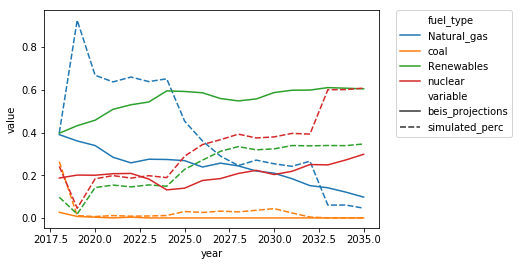

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_19-16-50-capacity_52152.csv


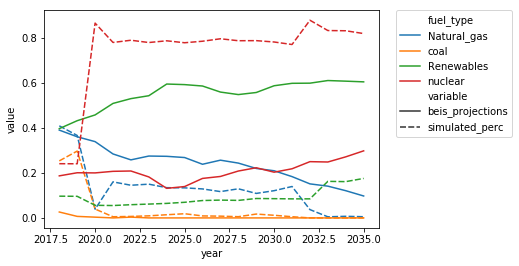

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-13-04-capacity_52152.csv


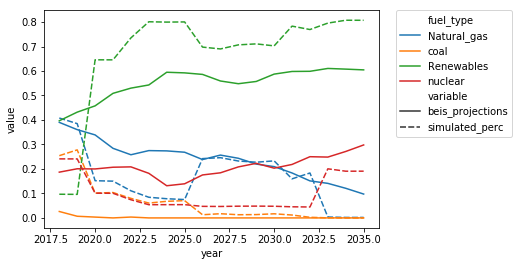

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_19-18-55-capacity_52152.csv


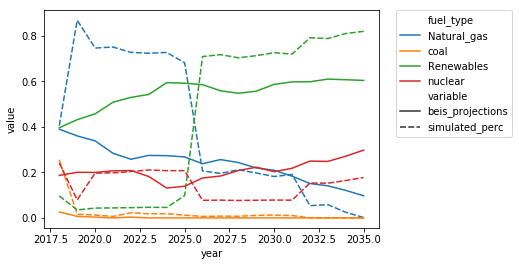

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-30-15-capacity_52152.csv


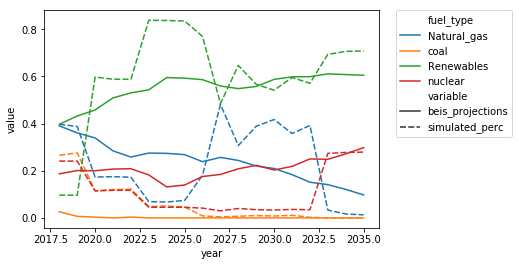

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-24-48-capacity_52152.csv


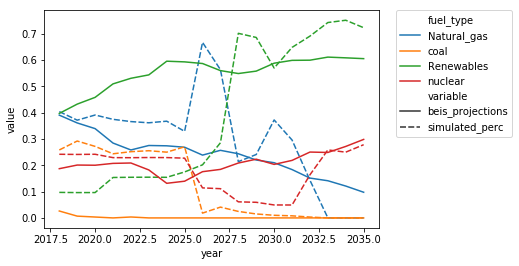

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-19-37-capacity_52152.csv


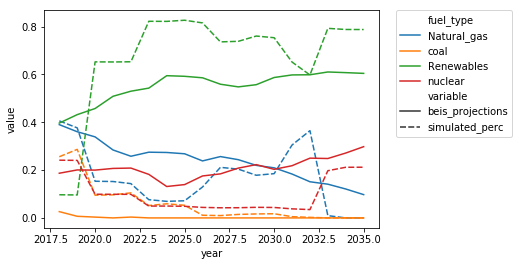

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_21-39-06-capacity_52152.csv


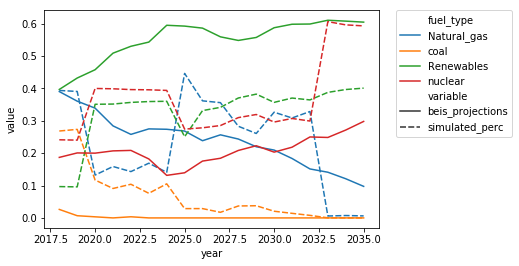

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-04-28-capacity_52152.csv


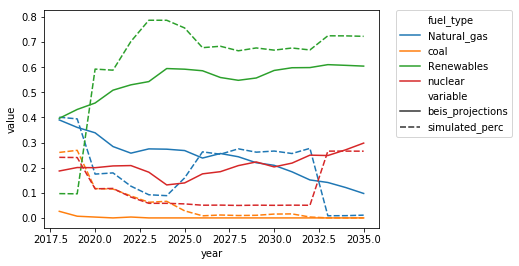

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-12-25-capacity_52152.csv


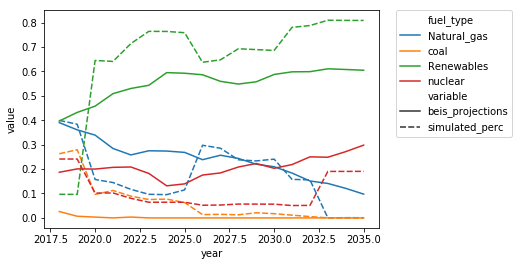

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_19-00-26-capacity_52152.csv


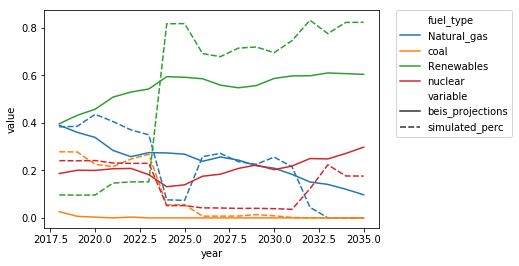

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-31-14-capacity_52152.csv


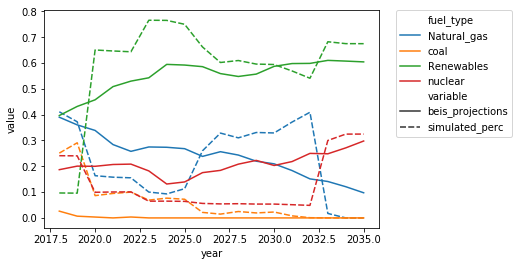

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_17-48-39-capacity_52152.csv


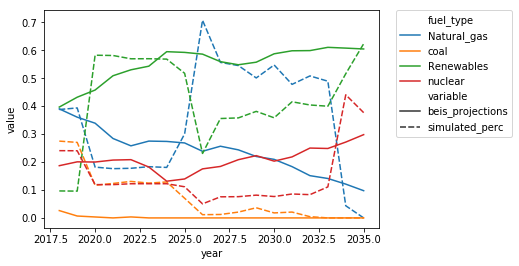

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-48-20-capacity_52152.csv


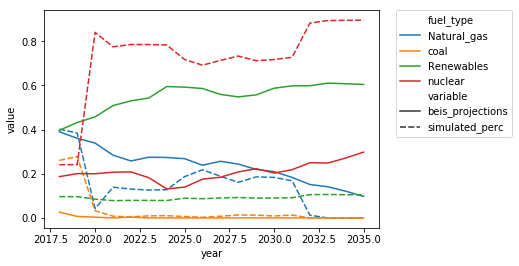

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-06-35-capacity_52152.csv


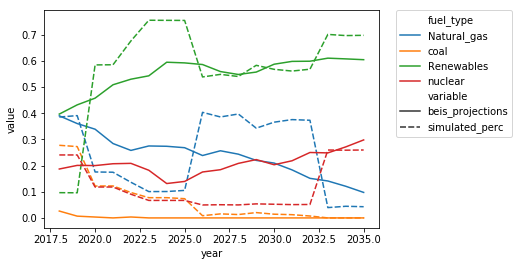

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_19-41-31-capacity_52152.csv


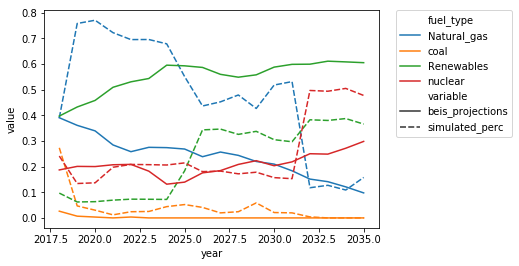

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-49-49-capacity_52152.csv


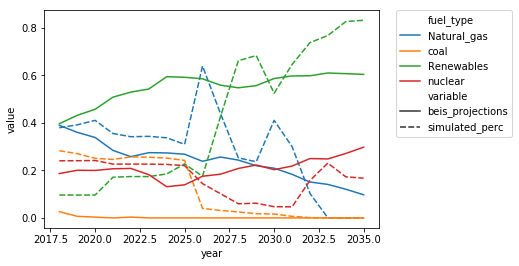

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-03-59-capacity_52152.csv


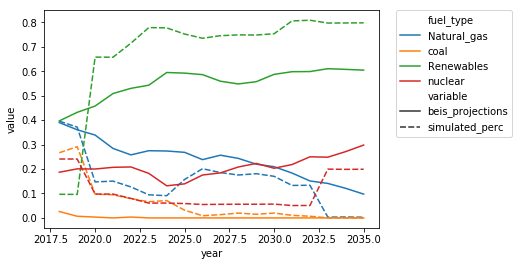

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_22-07-15-capacity_52152.csv


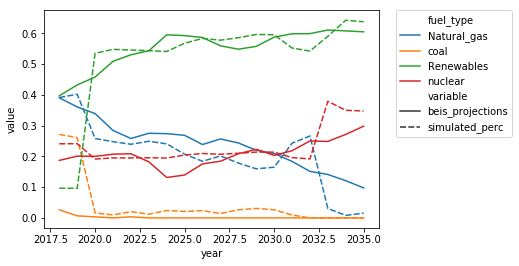

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_20-09-52-capacity_52152.csv


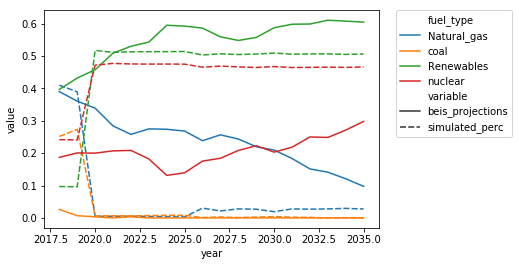

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-10-49-capacity_52152.csv


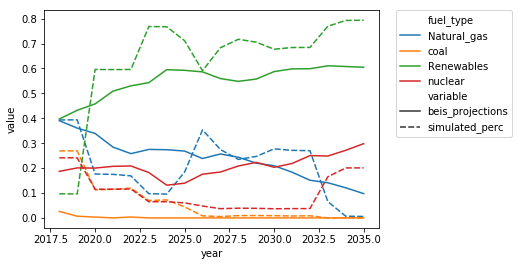

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-21-35-capacity_52152.csv


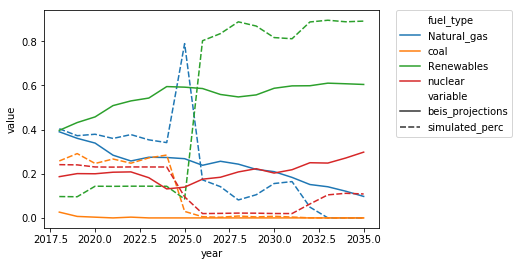

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-23-45-capacity_52152.csv


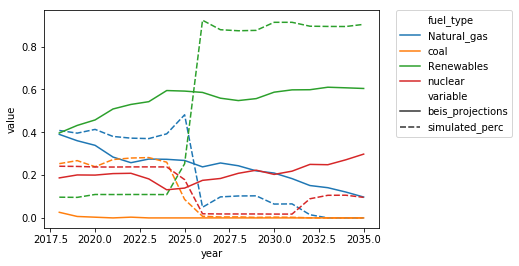

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_20-33-39-capacity_52152.csv


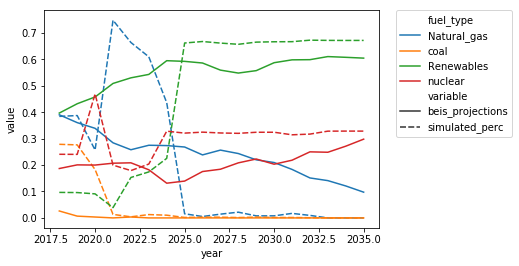

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-07-08-capacity_52152.csv


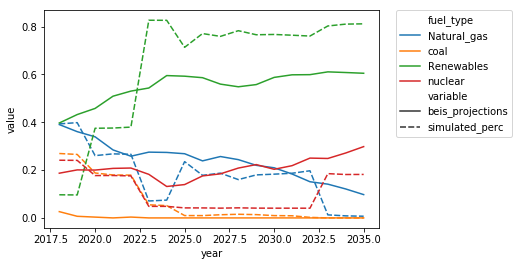

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_19-54-22-capacity_52152.csv


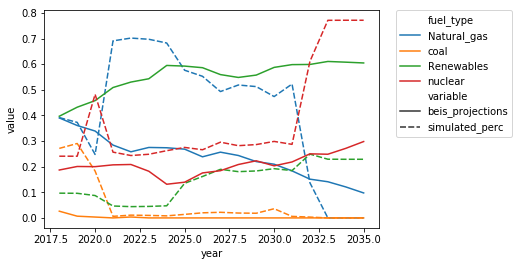

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-40-59-capacity_52152.csv


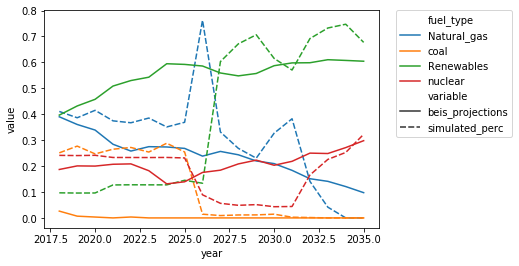

/Users/b1017579/Desktop/best_run_beis_comparison/demand_none-carbon_none-datetime_2019-10-25_18-26-54-capacity_52152.csv


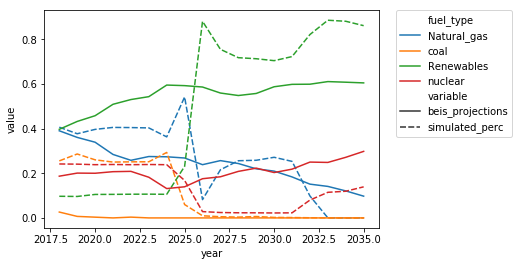

In [17]:
path = "/Users/b1017579/Desktop/best_run_beis_comparison"
all_files = glob.glob(path + "/*.csv")
results = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     results.append(df)
#     print(df)
    
    
# for result in results:
#     per_year_dat = get_projection_difference_sum(result)
#     per_year_dat = per_year_dat.rename({'actual_perc':"beis_projections"}, axis=1)
#     per_year_long = per_year_dat.drop(['value_actual', 'value_predicted'], axis=1).reset_index().melt(['year','fuel_type'])
#     sns.lineplot(data=per_year_long, x='year', hue='fuel_type', style='variable', y='value')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()
#     plt.close()
#     plt.xlim([2020,2032])

for filename in all_files:
    print(filename)
    result = pd.read_csv(filename, index_col=None, header=0)
    per_year_dat = get_projection_difference_sum(result)
    per_year_dat = per_year_dat.rename({'actual_perc':"beis_projections"}, axis=1)
    per_year_long = per_year_dat.drop(['value_actual', 'value_predicted'], axis=1).reset_index().melt(['year','fuel_type'])
    sns.lineplot(data=per_year_long, x='year', hue='fuel_type', style='variable', y='value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.close()


In [22]:
with open('/Users/b1017579/Desktop/out1.pkl', 'rb') as f:
    data1 = pickle.load(f)

with open('/Users/b1017579/Desktop/out2.pkl', 'rb') as f:
    data2 = pickle.load(f)
    

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


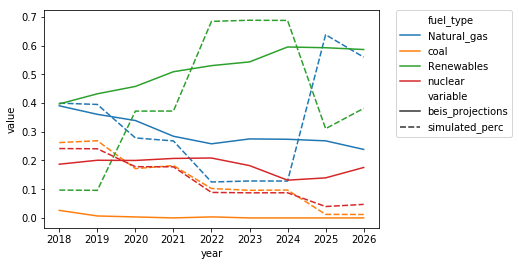

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


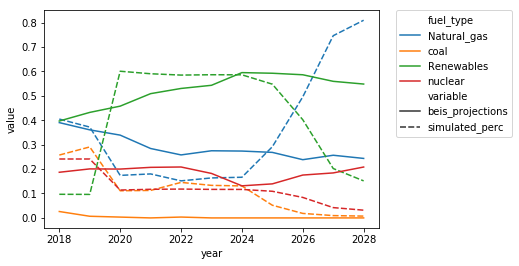

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


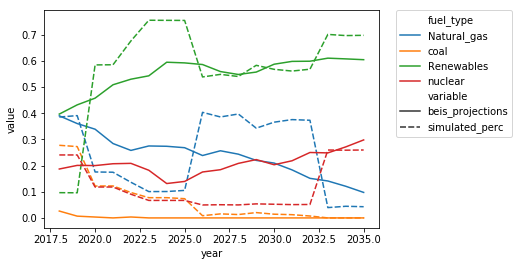

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


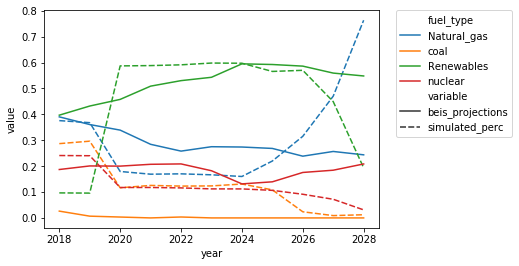

99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


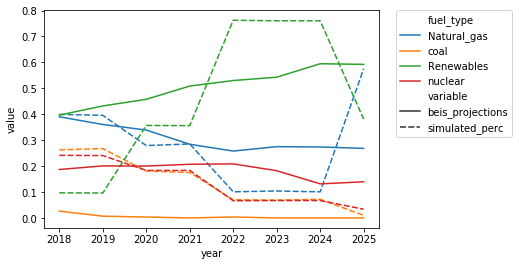

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


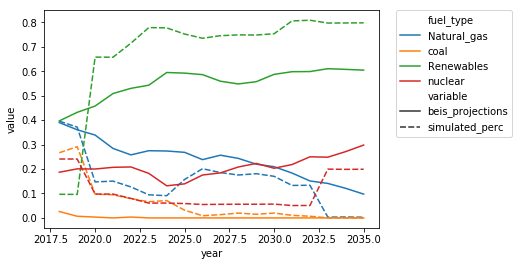

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


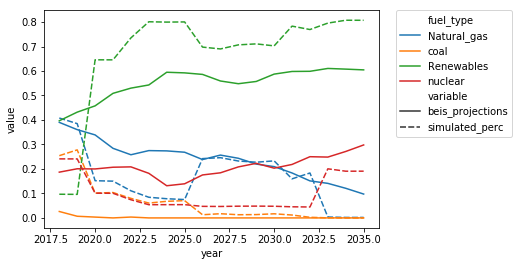

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


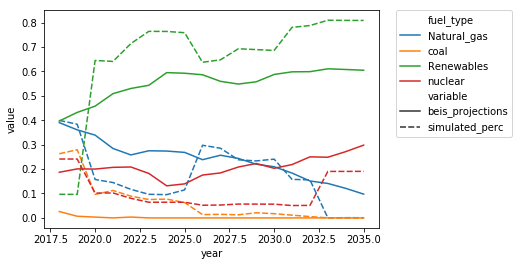

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


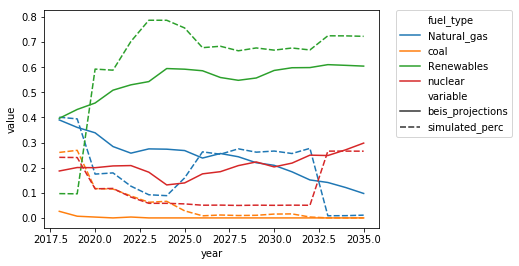

[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 2.44276478046317, 0.0010814175681300002, 17.97087764338538, 1.54918024e-06, -9.45892414520196, 0.00278239386267, -2.47083267943961, 0.0007711627583300001, -16.55858790939382, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 0.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


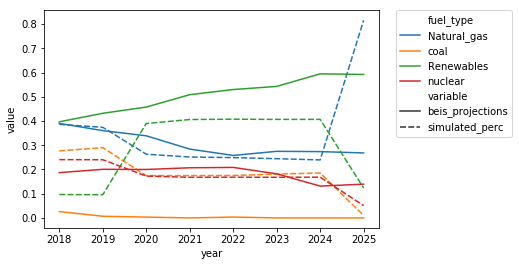

99999
[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 2.44276478046317, 0.0010814175681300002, 17.97087764338538, 1.54918024e-06, -9.45892414520196, 0.00278239386267, -2.47083267943961, 0.0007711627583300001, -16.55858790939382, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 0.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


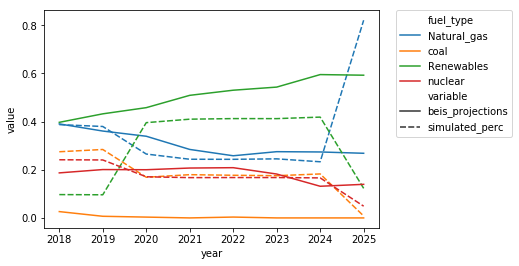

[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 2.44276478046317, 0.0010814175681300002, 17.97087764338538, 1.54918024e-06, -9.45892414520196, 0.00278239386267, -2.47083267943961, 0.0007711627583300001, -16.55858790939382, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 0.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


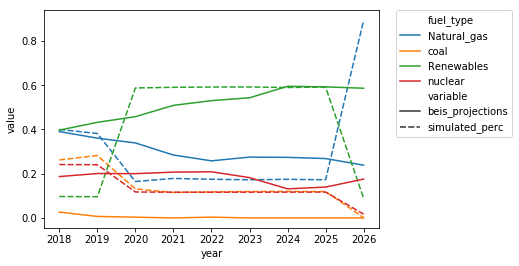

99999
[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 2.44276478046317, 0.0010814175681300002, 17.97087764338538, 1.54918024e-06, -9.45892414520196, 0.00278239386267, -2.47083267943961, 0.0007711627583300001, -16.55858790939382, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 0.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


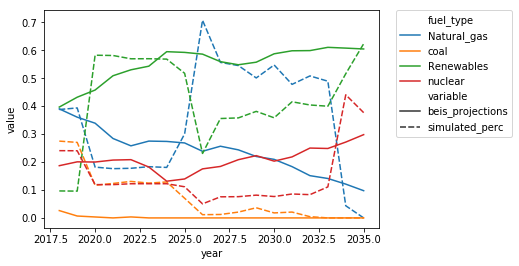

[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 2.44276478046317, 0.0010814175681300002, 17.97087764338538, 1.54918024e-06, -9.45892414520196, 0.00278239386267, -2.47083267943961, 0.0007711627583300001, -16.55858790939382, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 0.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


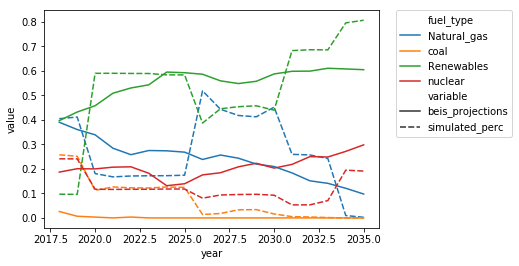

[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 2.44276478046317, 0.0010814175681300002, 17.97087764338538, 1.54918024e-06, -9.45892414520196, 0.00278239386267, -2.47083267943961, 0.0007711627583300001, -16.55858790939382, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 0.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


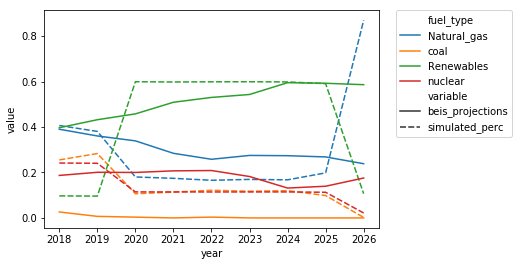

[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 2.44276478046317, 0.0010814175681300002, 17.97087764338538, 1.54918024e-06, -9.45892414520196, 0.00278239386267, -2.47083267943961, 0.0007711627583300001, -16.55858790939382, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 0.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


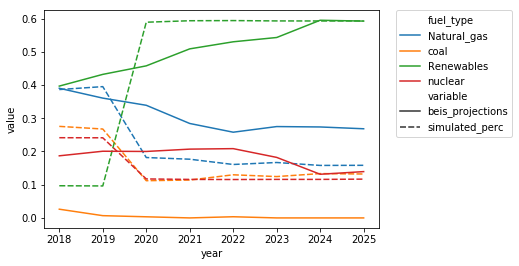

99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


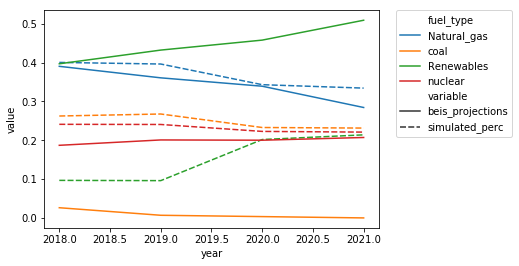

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


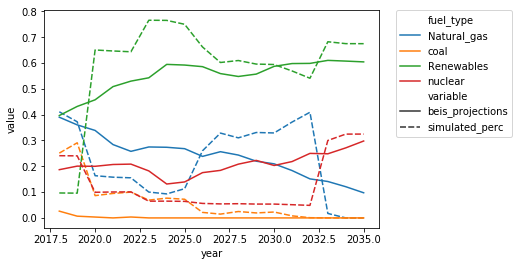

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


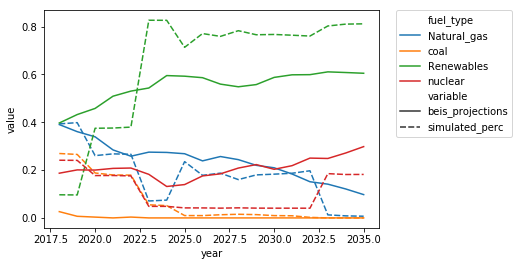

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


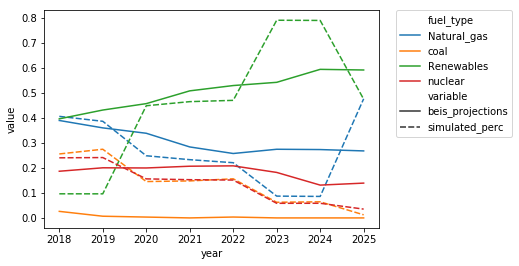

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


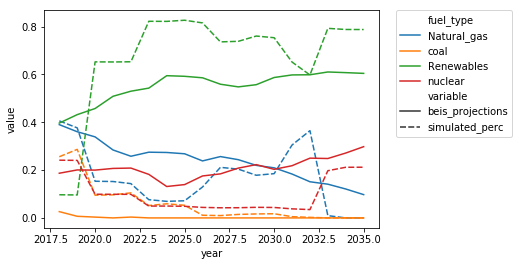

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


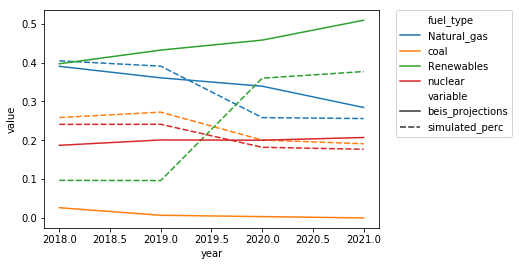

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


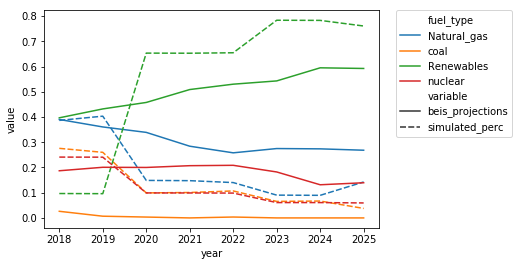

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


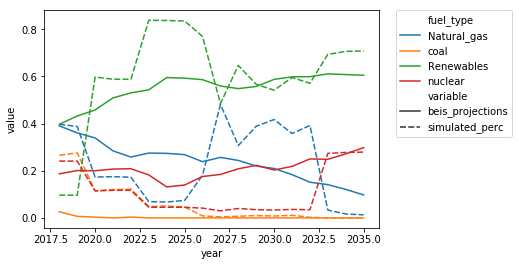

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


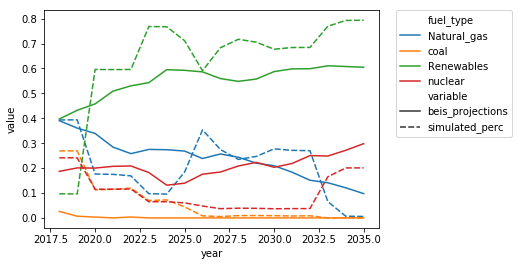

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


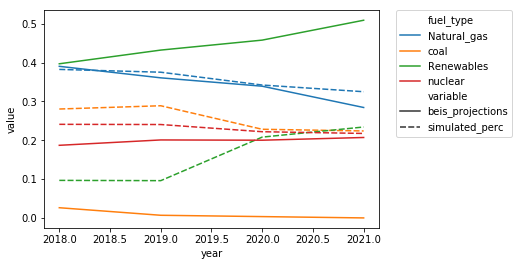

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


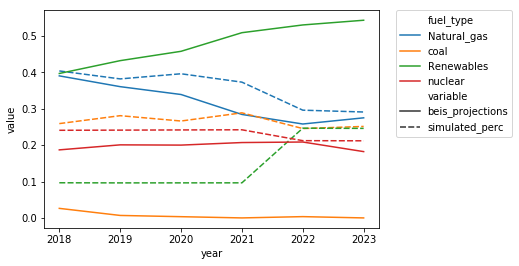

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


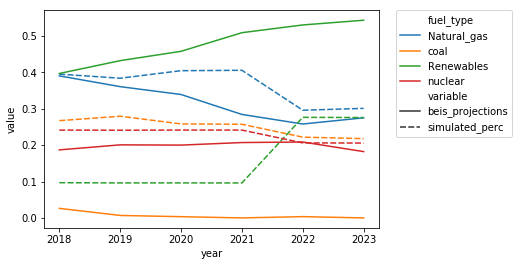

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


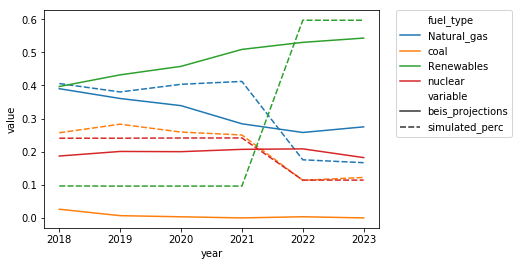

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


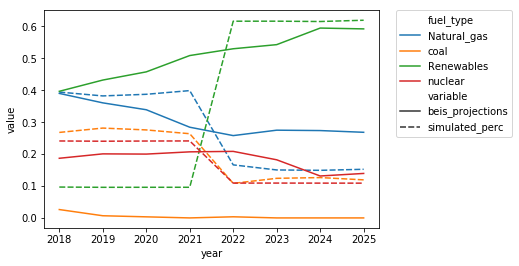

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


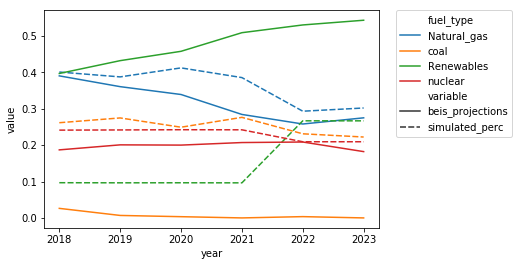

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


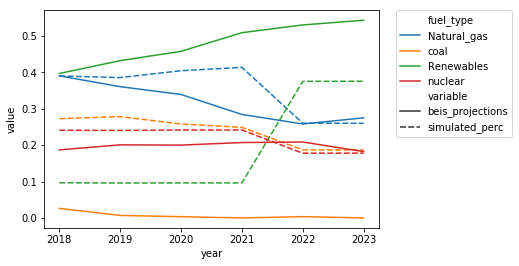

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


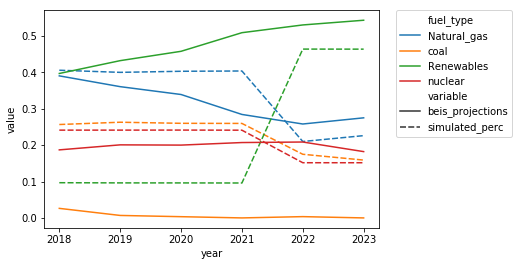

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


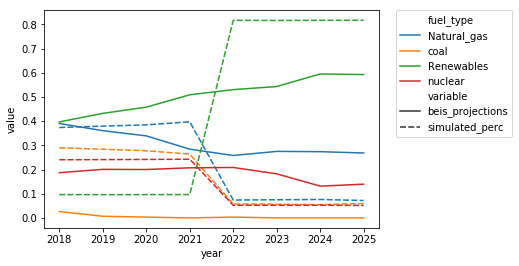

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


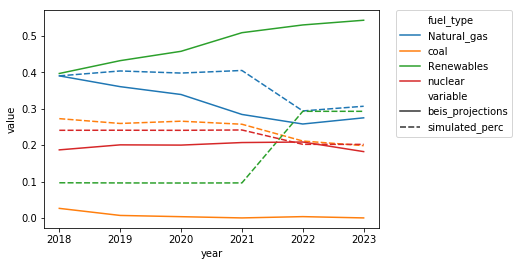

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


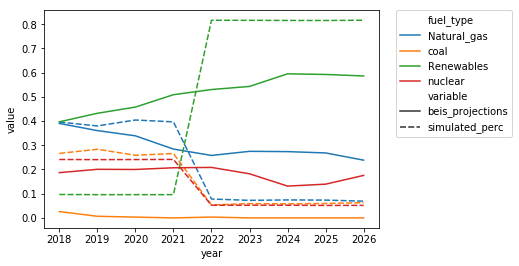

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


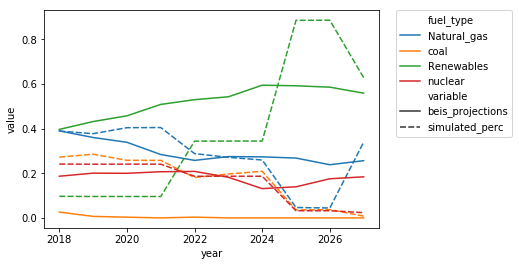

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


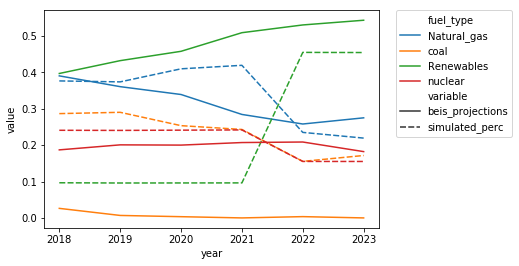

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


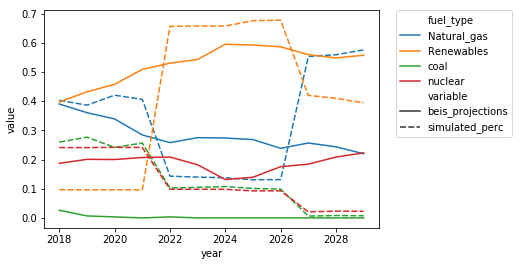

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


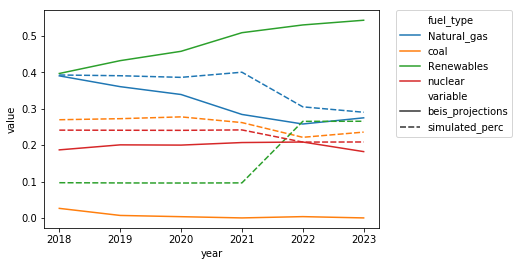

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


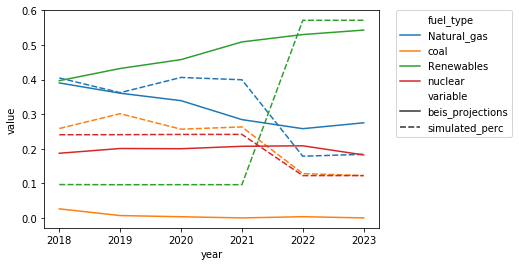

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


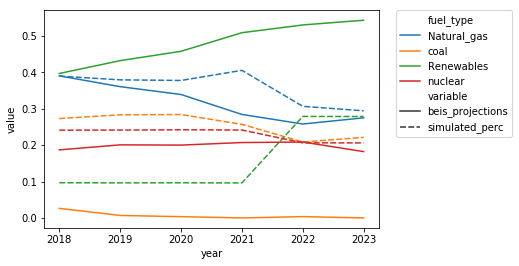

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


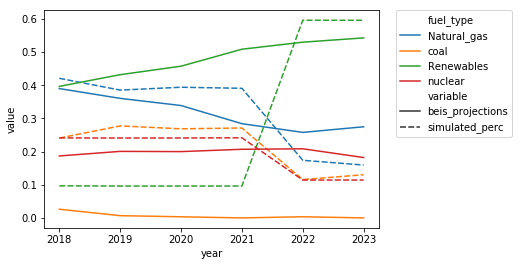

[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


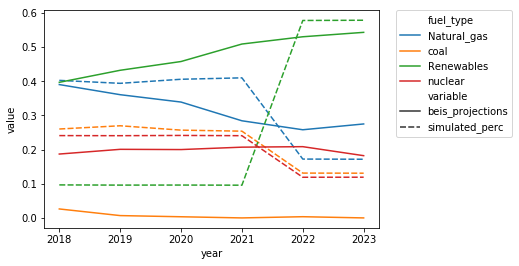

99999
[0.00085103966297, 6.07348253383911, 0.00037381683411, -14.26871925075561, 0.00037344430353, 15.48800403775501, 0.0012424092626, 41.42988017617473, 0.00049755317958, -20.25037393249956, 0.0008102098872000001, 20.44822618339845, 0.0022863834951399997, 8.36901349346692, 0.00021942006309, 24.22523330282154, 0.0012823202236099999, 42.7543386951961, 0.00197948329378, 39.85020636613533, 0.0011353858661, 39.17550570902763, 0.0014342648704800001, -24.47494205506021, 0.00150481946062, 0.45443391781952003, 0.00169034198576, -17.39298931476864, 0.00081367256731, -12.322127116276528, 0.00123247951979, -25.36243875380406, 0.00147254954693, -5.452417900888309, 89.1586815901276, 0.00020327756491, 0.0007204967263300001]


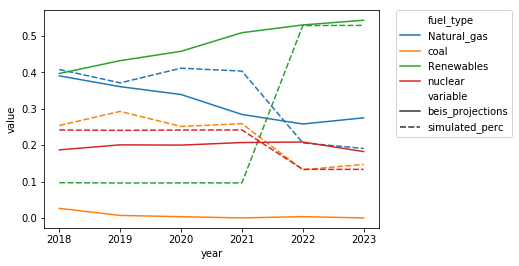

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


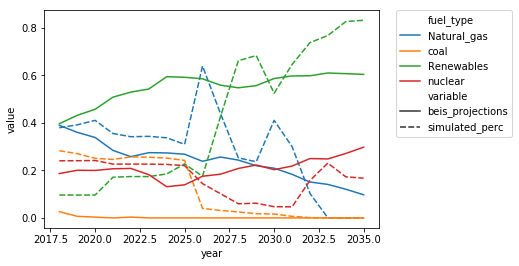

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


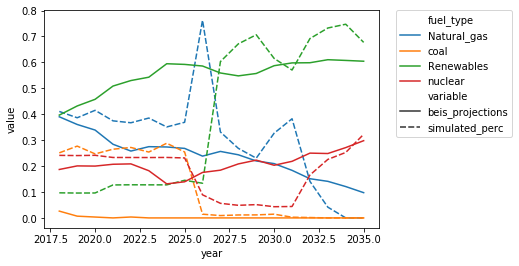

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


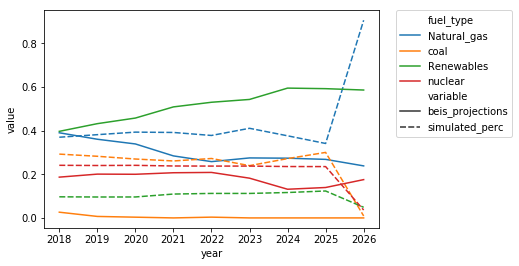

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


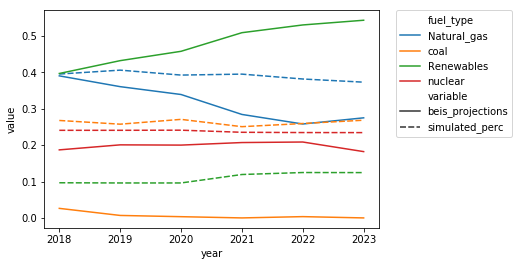

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


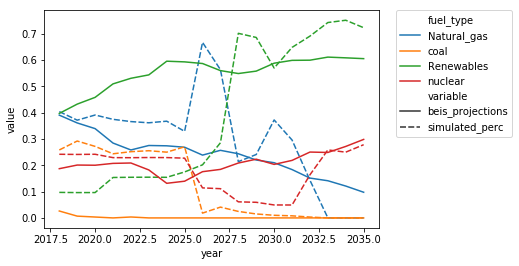

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


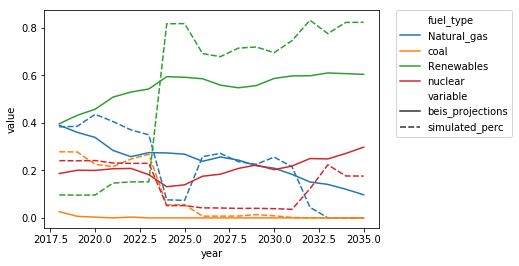

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


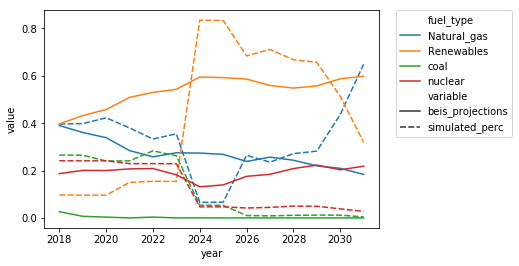

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


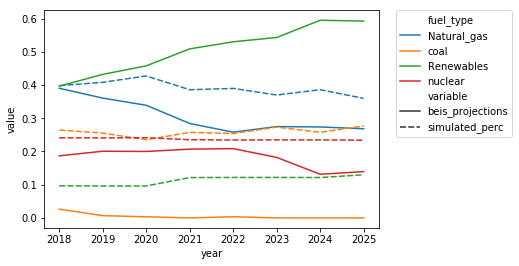

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


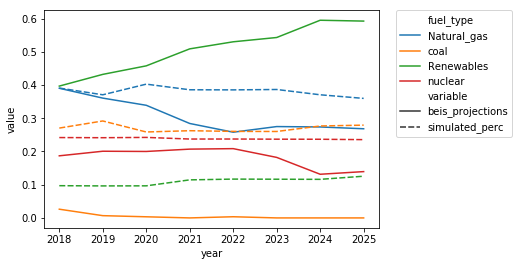

[0.00156925181369, -20.608903186833988, 0.0006787065813099999, 1.86199473663874, 0.0021869609253200003, 1.9484568311405, 0.0014323925060199998, 3.2812013747012996, 0.00102959120608, 0.0, 0.0028655913718700003, 26.192640934903192, 0.00253421322792, -8.32605663739421, 0.00030555913648, 49.357287861533365, 0.0015319828109500002, 40.81497219164989, 1.0, 12.51162202810149, 0.00148400669862, 9.136304102365768, 0.00237709767261, -19.53559315996288, 0.00177218953201, 38.93665118088993, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


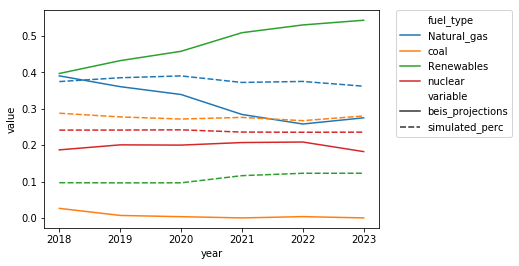

[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


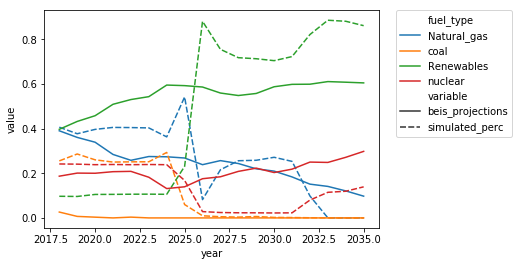

[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


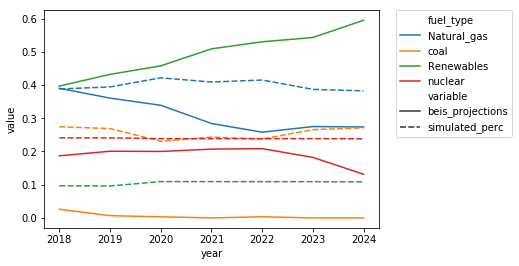

[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


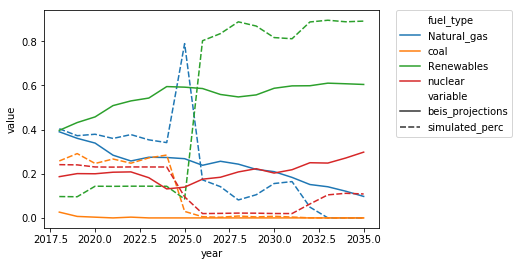

[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


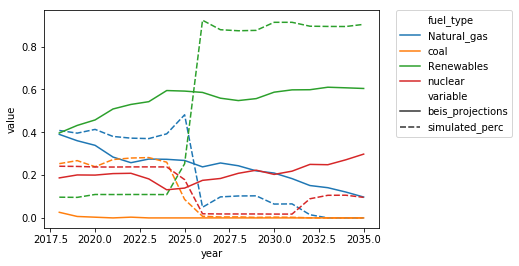

[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


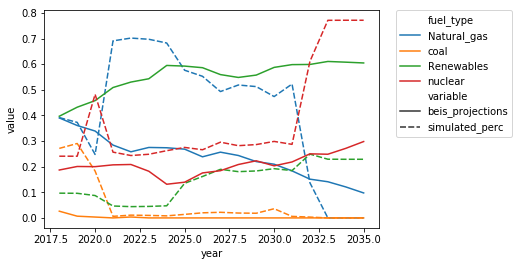

[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


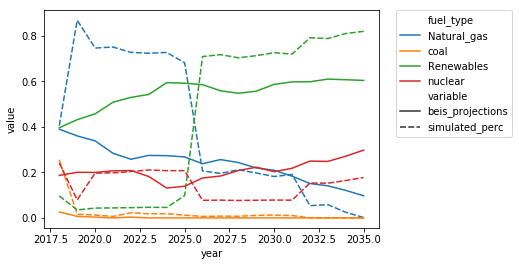

99999
[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


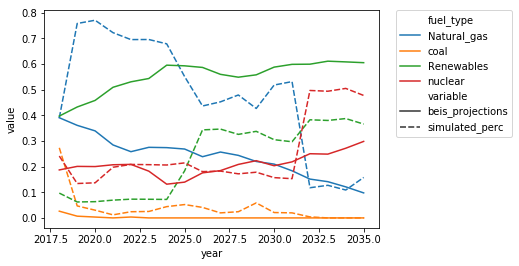

99999
[0.00035891531183, 5.12278905625826, 0.00097638281416, 49.091703355073825, 0.00073898388762, -24.63395619496044, 0.0018354364702299999, -17.41598655341934, 0.00022374815999000002, 7.66799254640063, 0.00074256530289, -22.28083246092687, 0.00254891601537, -15.573033224865279, 0.0027394780128000003, 35.81552060938266, 0.0013931762545999998, 13.56139522318001, 0.00069278337506, -6.30000460774633, 0.00052709144209, 5.79842563602338, 0.0009449062591, -25.074435880339603, 0.0, 29.61483183643982, 0.00269177696491, 4.0297524921065095, 0.00024340518892, -28.86614015431534, 0.00204003002334, -26.265171162845288, 0.0021547069051999997, 8.19077011509531, 134.82067502150608, 0.00030054162876, 0.00015114077621]


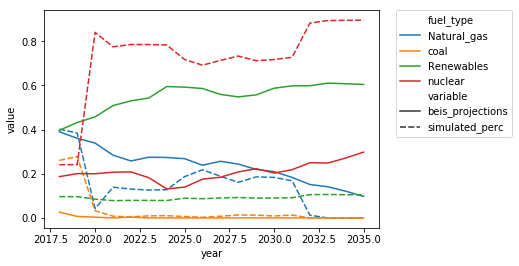

[0.00261015146468, 29.22065744598557, 0.00094499611538, -11.42581612214406, 0.0009662115862999999, 8.26965272324614, 0.00214860406703, -2.91073122503079, 0.00297483198867, 40.809954003231844, 0.00221768142198, 12.153854222495761, 0.00108560033409, 43.87869464288751, 0.0015258293349300002, 20.3253796633369, 7.570573542e-05, -19.600542155823238, 0.00200465124343, 11.496470350723119, 0.00234355494066, 6.88352657304144, 0.0012186527184200001, 21.79434826043747, 0.00124314621386, -18.31747322714218, 0.00065699375036, 11.95040494203867, 0.00262817020765, 4.51433974224664, 0.00225329704091, 18.266383505956192, 0.0018236155409000001, 33.2527013831351, 88.17276337887233, 0.0004692516312, 3.123151331e-05]


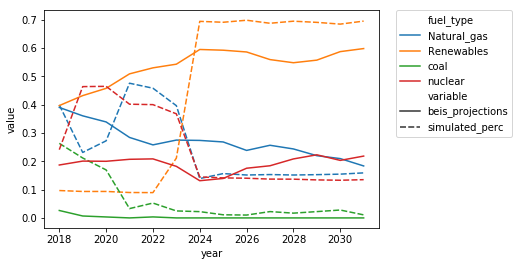

99999
[0.00261015146468, 29.22065744598557, 0.00094499611538, -11.42581612214406, 0.0009662115862999999, 8.26965272324614, 0.00214860406703, -2.91073122503079, 0.00297483198867, 40.809954003231844, 0.00221768142198, 12.153854222495761, 0.00108560033409, 43.87869464288751, 0.0015258293349300002, 20.3253796633369, 7.570573542e-05, -19.600542155823238, 0.00200465124343, 11.496470350723119, 0.00234355494066, 6.88352657304144, 0.0012186527184200001, 21.79434826043747, 0.00124314621386, -18.31747322714218, 0.00065699375036, 11.95040494203867, 0.00262817020765, 4.51433974224664, 0.00225329704091, 18.266383505956192, 0.0018236155409000001, 33.2527013831351, 88.17276337887233, 0.0004692516312, 3.123151331e-05]


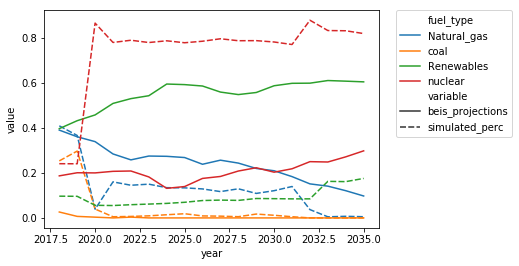

[0.00261015146468, 29.22065744598557, 0.00094499611538, -11.42581612214406, 0.0009662115862999999, 8.26965272324614, 0.00214860406703, -2.91073122503079, 0.00297483198867, 40.809954003231844, 0.00221768142198, 12.153854222495761, 0.00108560033409, 43.87869464288751, 0.0015258293349300002, 20.3253796633369, 7.570573542e-05, -19.600542155823238, 0.00200465124343, 11.496470350723119, 0.00234355494066, 6.88352657304144, 0.0012186527184200001, 21.79434826043747, 0.00124314621386, -18.31747322714218, 0.00065699375036, 11.95040494203867, 0.00262817020765, 4.51433974224664, 0.00225329704091, 18.266383505956192, 0.0018236155409000001, 33.2527013831351, 88.17276337887233, 0.0004692516312, 3.123151331e-05]


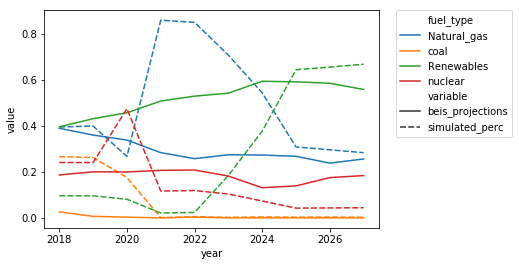

99999
99999
[0.00261015146468, 29.22065744598557, 0.00094499611538, -11.42581612214406, 0.0009662115862999999, 8.26965272324614, 0.00214860406703, -2.91073122503079, 0.00297483198867, 40.809954003231844, 0.00221768142198, 12.153854222495761, 0.00108560033409, 43.87869464288751, 0.0015258293349300002, 20.3253796633369, 7.570573542e-05, -19.600542155823238, 0.00200465124343, 11.496470350723119, 0.00234355494066, 6.88352657304144, 0.0012186527184200001, 21.79434826043747, 0.00124314621386, -18.31747322714218, 0.00065699375036, 11.95040494203867, 0.00262817020765, 4.51433974224664, 0.00225329704091, 18.266383505956192, 0.0018236155409000001, 33.2527013831351, 88.17276337887233, 0.0004692516312, 3.123151331e-05]


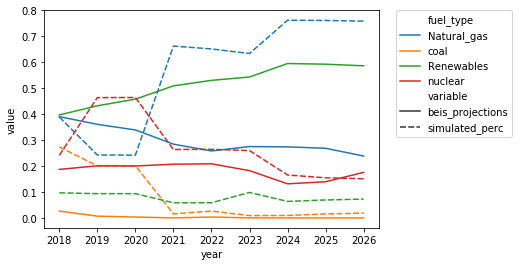

[0.00261015146468, 29.22065744598557, 0.00094499611538, -11.42581612214406, 0.0009662115862999999, 8.26965272324614, 0.00214860406703, -2.91073122503079, 0.00297483198867, 40.809954003231844, 0.00221768142198, 12.153854222495761, 0.00108560033409, 43.87869464288751, 0.0015258293349300002, 20.3253796633369, 7.570573542e-05, -19.600542155823238, 0.00200465124343, 11.496470350723119, 0.00234355494066, 6.88352657304144, 0.0012186527184200001, 21.79434826043747, 0.00124314621386, -18.31747322714218, 0.00065699375036, 11.95040494203867, 0.00262817020765, 4.51433974224664, 0.00225329704091, 18.266383505956192, 0.0018236155409000001, 33.2527013831351, 88.17276337887233, 0.0004692516312, 3.123151331e-05]


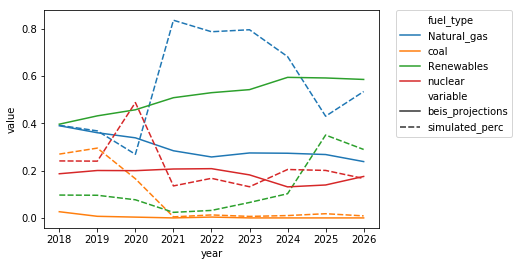

99999
[0.00261015146468, 29.22065744598557, 0.00094499611538, -11.42581612214406, 0.0009662115862999999, 8.26965272324614, 0.00214860406703, -2.91073122503079, 0.00297483198867, 40.809954003231844, 0.00221768142198, 12.153854222495761, 0.00108560033409, 43.87869464288751, 0.0015258293349300002, 20.3253796633369, 7.570573542e-05, -19.600542155823238, 0.00200465124343, 11.496470350723119, 0.00234355494066, 6.88352657304144, 0.0012186527184200001, 21.79434826043747, 0.00124314621386, -18.31747322714218, 0.00065699375036, 11.95040494203867, 0.00262817020765, 4.51433974224664, 0.00225329704091, 18.266383505956192, 0.0018236155409000001, 33.2527013831351, 88.17276337887233, 0.0004692516312, 3.123151331e-05]


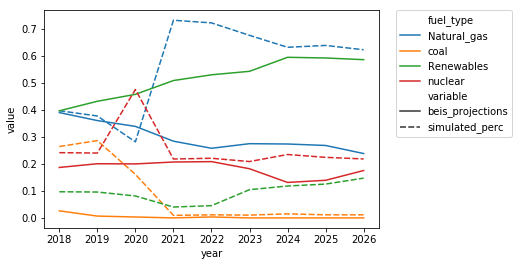

[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 10.07673785135837, 0.0008971569217100001, 8.600310282496691, 0.00131121520926, 47.4335453613577, 2.417664176e-05, -9.9028414934864, 0.00033824132781, 49.131784115293506, 0.0023160472696799996, -28.91090821314879, 0.00274228104291, 0.6765836569334699, 0.00272037652542, -24.09439344269603, 0.0011056561100899998, -15.24935326007066, 0.0023147583691599995, 4.862993170373191, 0.00024881810015, 27.73230483932365, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


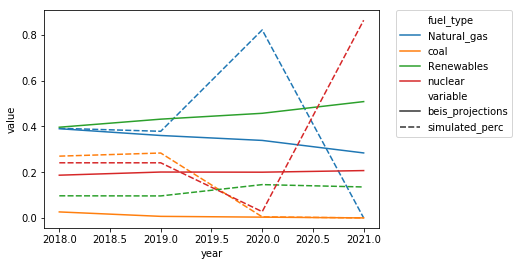

99999
99999
99999
99999
99999
99999
99999
99999
[0.00156925181369, 17.18127793664264, 0.00268364671408, 46.19691356647337, 0.00245009733376, 10.07673785135837, 0.0008971569217100001, 8.600310282496691, 0.00131121520926, 47.4335453613577, 2.417664176e-05, -9.9028414934864, 0.00033824132781, 49.131784115293506, 0.0023160472696799996, -28.91090821314879, 0.00274228104291, 0.6765836569334699, 0.00272037652542, -24.09439344269603, 0.0011056561100899998, -15.24935326007066, 0.0023147583691599995, 4.862993170373191, 0.00024881810015, 27.73230483932365, 0.00267083126902, -22.235463941048422, 0.00224383841556, 11.27110150363208, 0.00254924908021, -16.609474598841132, 0.00237215594079, 24.438708184472798, 124.13460995962132, 0.0008949911096, 0.00030132022804]


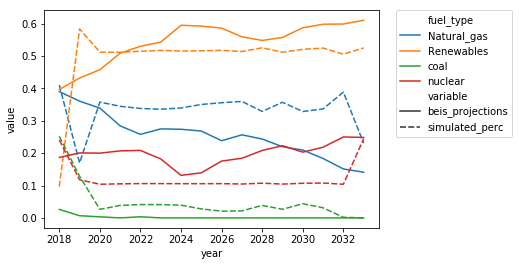

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


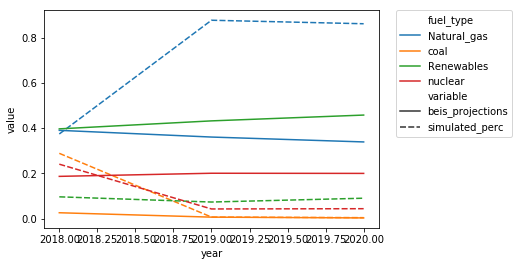

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


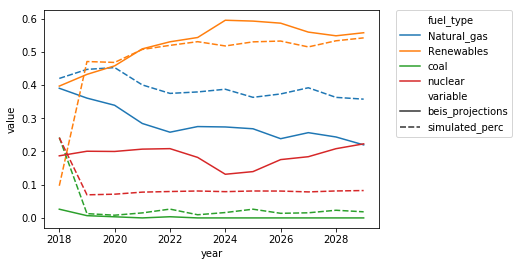

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


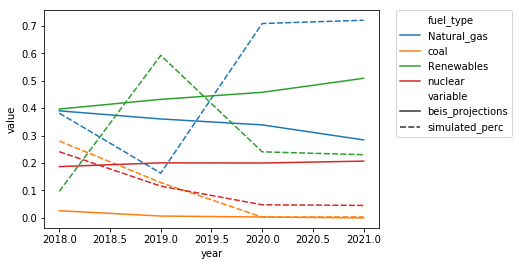

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


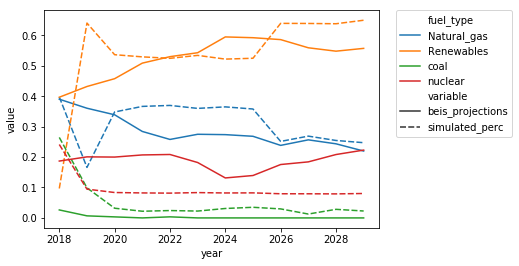

99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


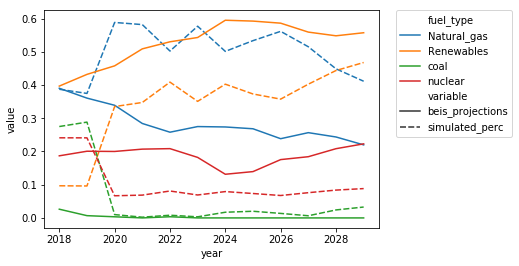

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


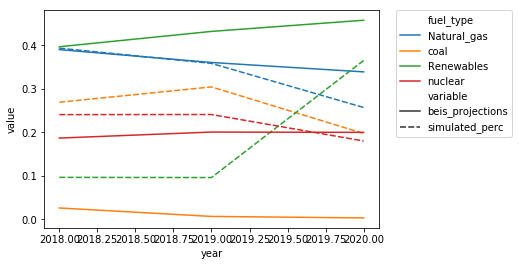

99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


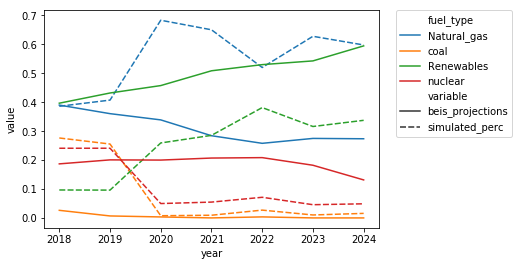

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


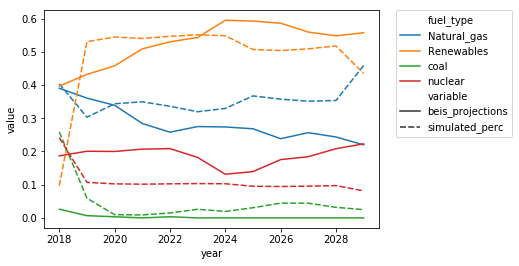

[0.00258794176684, -19.83189433838247, 0.00146115880334, 49.38866647986005, 0.0006224113054299999, -13.252269126408251, 0.0016009710149999998, 37.787429899511686, 0.00141401522807, -12.75359959125418, 0.0024805124644600002, -12.829895844682689, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 44.607856420645724, 0.00050418593542, 39.01077073004474, 0.0025804295656799998, 48.58575319632431, 3.1409355e-06, -17.139935154167162, 0.00153980229107, 49.69239937487186, 0.0009699973328699999, 48.97032464420628, 105.07600787993904, 0.0007544422689400001, 0.0008560714432400001]


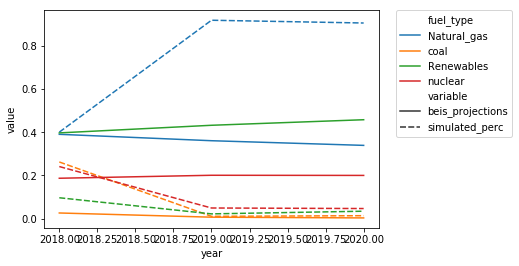

[0.00258794176684, -19.83189433838247, 0.00146115880334, 49.38866647986005, 0.0006224113054299999, -13.252269126408251, 0.0016009710149999998, 37.787429899511686, 0.00141401522807, -12.75359959125418, 0.0024805124644600002, -12.829895844682689, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 44.607856420645724, 0.00050418593542, 39.01077073004474, 0.0025804295656799998, 48.58575319632431, 3.1409355e-06, -17.139935154167162, 0.00153980229107, 49.69239937487186, 0.0009699973328699999, 48.97032464420628, 105.07600787993904, 0.0007544422689400001, 0.0008560714432400001]


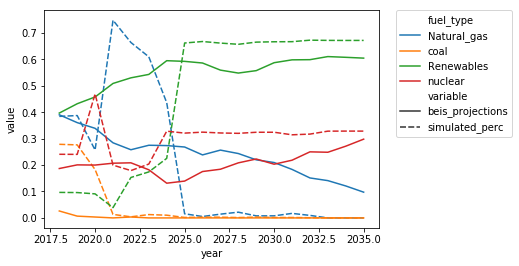

99999
99999
[0.00258794176684, -19.83189433838247, 0.00146115880334, 49.38866647986005, 0.0006224113054299999, -13.252269126408251, 0.0016009710149999998, 37.787429899511686, 0.00141401522807, -12.75359959125418, 0.0024805124644600002, -12.829895844682689, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 44.607856420645724, 0.00050418593542, 39.01077073004474, 0.0025804295656799998, 48.58575319632431, 3.1409355e-06, -17.139935154167162, 0.00153980229107, 49.69239937487186, 0.0009699973328699999, 48.97032464420628, 105.07600787993904, 0.0007544422689400001, 0.0008560714432400001]


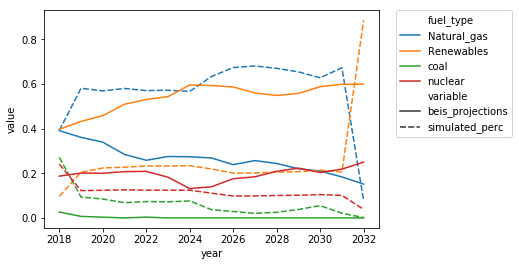

[0.00258794176684, -19.83189433838247, 0.00146115880334, 49.38866647986005, 0.0006224113054299999, -13.252269126408251, 0.0016009710149999998, 37.787429899511686, 0.00141401522807, -12.75359959125418, 0.0024805124644600002, -12.829895844682689, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 44.607856420645724, 0.00050418593542, 39.01077073004474, 0.0025804295656799998, 48.58575319632431, 3.1409355e-06, -17.139935154167162, 0.00153980229107, 49.69239937487186, 0.0009699973328699999, 48.97032464420628, 105.07600787993904, 0.0007544422689400001, 0.0008560714432400001]


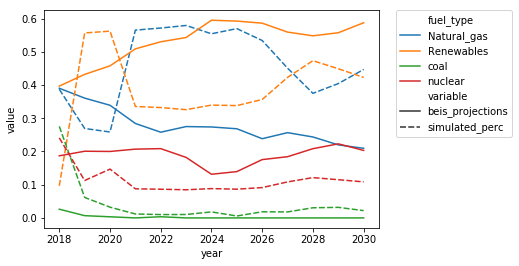

[0.00258794176684, -19.83189433838247, 0.00146115880334, 49.38866647986005, 0.0006224113054299999, -13.252269126408251, 0.0016009710149999998, 37.787429899511686, 0.00141401522807, -12.75359959125418, 0.0024805124644600002, -12.829895844682689, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 44.607856420645724, 0.00050418593542, 39.01077073004474, 0.0025804295656799998, 48.58575319632431, 3.1409355e-06, -17.139935154167162, 0.00153980229107, 49.69239937487186, 0.0009699973328699999, 48.97032464420628, 105.07600787993904, 0.0007544422689400001, 0.0008560714432400001]


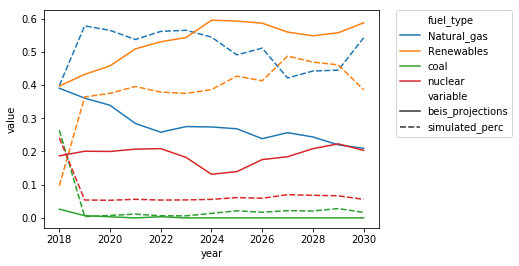

99999
99999
[0.00258794176684, -19.83189433838247, 0.00146115880334, 49.38866647986005, 0.0006224113054299999, -13.252269126408251, 0.0016009710149999998, 37.787429899511686, 0.00141401522807, -12.75359959125418, 0.0024805124644600002, -12.829895844682689, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00121797220108, -21.87347804941957, 0.0007197398987200001, 24.090872932390013, 0.00042304289398, 44.607856420645724, 0.00050418593542, 39.01077073004474, 0.0025804295656799998, 48.58575319632431, 3.1409355e-06, -17.139935154167162, 0.00153980229107, 49.69239937487186, 0.0009699973328699999, 48.97032464420628, 105.07600787993904, 0.0007544422689400001, 0.0008560714432400001]


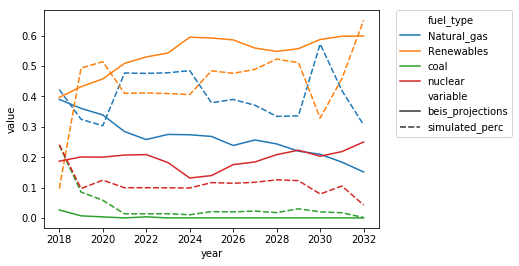

99999
99999
99999
99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.00016104706555000002, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


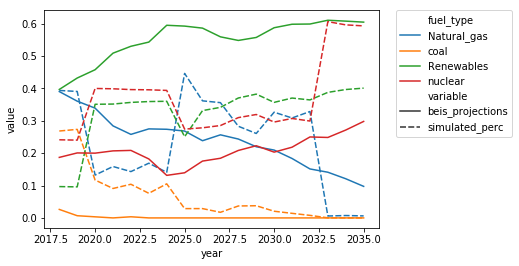

99999
99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.00016104706555000002, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


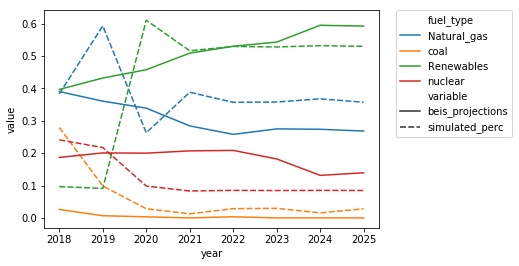

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.00016104706555000002, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0005481249937000001, 0.00059945111227]


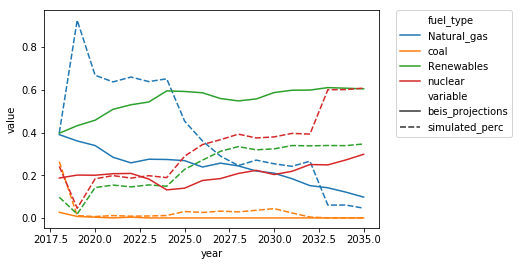

99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


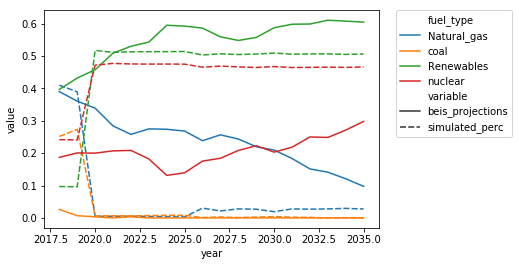

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


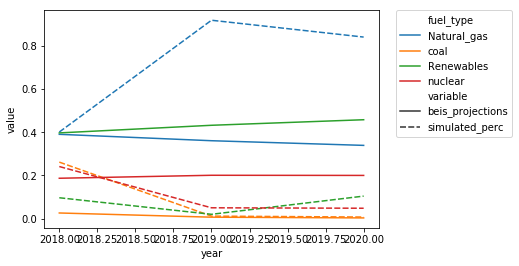

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


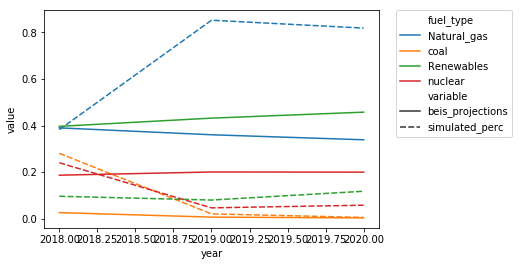

99999
99999
99999
99999
99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


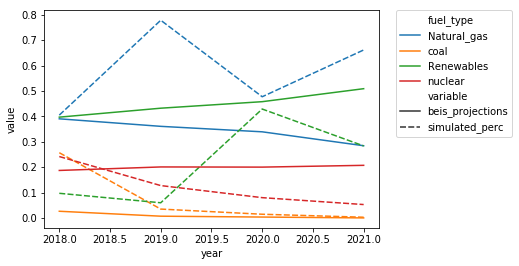

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


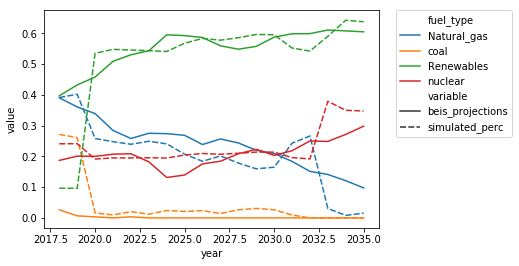

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


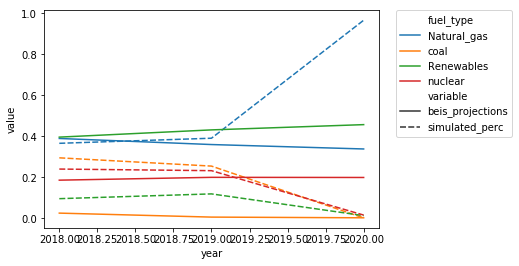

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


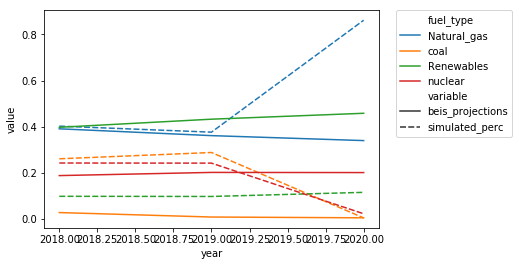

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


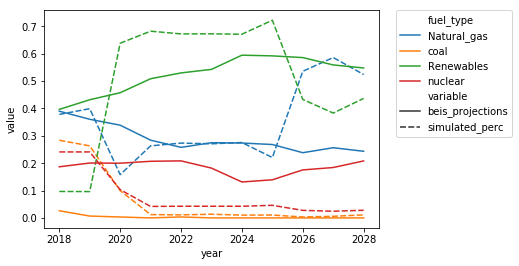

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


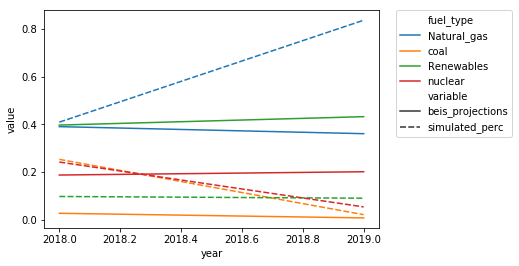

99999
[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


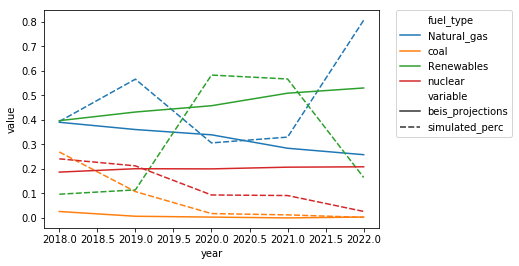

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


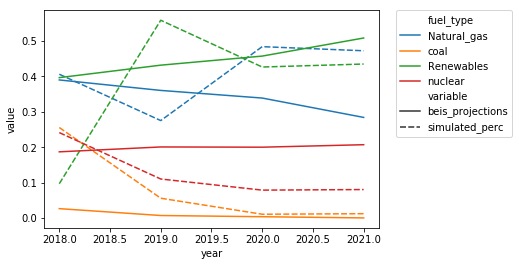

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


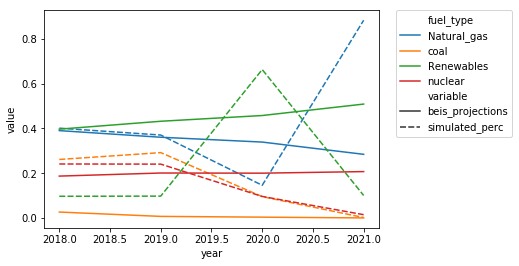

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


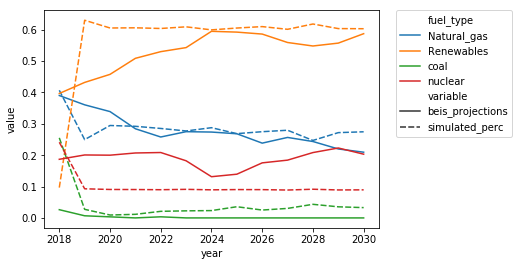

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 40.74731543938266, 0.0024046471141100003, 34.43480109190594, 0.0028418648257399997, -20.88014916953091, 0.0008341078970800001, -27.022843105518852, 0.00026661557773, 45.900874746356315, 0.00040255609489999995, -16.50327275413227, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 0.0, 0.0005481249937000001, 0.0]


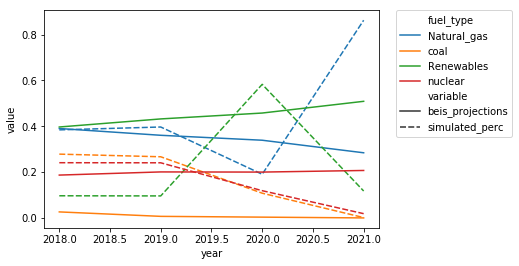

In [29]:
for params, table in zip(data1, data2):
    print(params)
    if table is not 0:
        per_year_dat = get_projection_difference_sum(table)
    else:
        continue
    per_year_dat = per_year_dat.rename({'actual_perc':"beis_projections"}, axis=1)
    per_year_long = per_year_dat.drop(['value_actual', 'value_predicted'], axis=1).reset_index().melt(['year','fuel_type'])
    sns.lineplot(data=per_year_long, x='year', hue='fuel_type', style='variable', y='value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.close()

[0.00121256259168, 46.850377392563864, 0.0029982421515, 28.9229765616468, 0.00106156336814, 18.370337670063762, 0.00228312539654, 0.0, 0.0024046471141100003, 34.43480109190594, 0.0, -20.88014916953091, 0.0, 8.15032953348701, 0.00200271495761, -12.546185375581802, 0.00155518243668, 39.791132970522796, 0.00027449937576, 8.42878689508516, 0.00111989525697, 19.81640207212787, 0.00224091998324, 5.26288570922149, 0.00209189353332, -5.9117317131295195, 0.00240696026847, -5.0144941135222, 0.00021183142492999999, -1.29658413335784, 0.00039441444392000004, -11.41659250225168, 0.0021988838824299997, 12.633572943294599, 120.21276910611674, 0.0, 0.00059945111227]


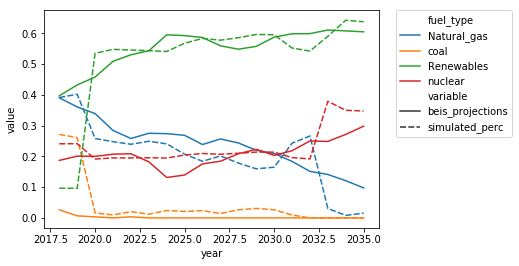

In [32]:
print(data1[-11])
table = data2[-11]
per_year_dat = get_projection_difference_sum(table)
per_year_dat = per_year_dat.rename({'actual_perc':"beis_projections"}, axis=1)
per_year_long = per_year_dat.drop(['value_actual', 'value_predicted'], axis=1).reset_index().melt(['year','fuel_type'])
sns.lineplot(data=per_year_long, x='year', hue='fuel_type', style='variable', y='value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

In [56]:
best_params = data1[-11]
best_params

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
    
x_lines = []
y_lines = []
years = []
all_prices = []
for i, (slope, intercept) in enumerate(zip(best_params[:-2:2], best_params[1:-2:2])):
#     print("{}, {}".format(slope,intercept))
    X_line = np.arange(0, 60000, 500)
    Y_line = X_line *slope +  intercept
    
    all_prices.append(pd.DataFrame({"Y_axis":Y_line, 'X_axis':X_line, "year":i}))
#     x_lines.append(X_line)
#     y_lines.append(Y_line)
#     years.append(i)

# pd.DataFrame({"Y_axis":y_lines, 'X_axis':x_lines, "year":years})
prices_df = pd.concat(all_prices)
prices_df.head()

Y_axis  X_axis  year
0  46.850377       0     0
1  47.456659     500     0
2  48.062940    1000     0
3  48.669221    1500     0
4  49.275503    2000     0

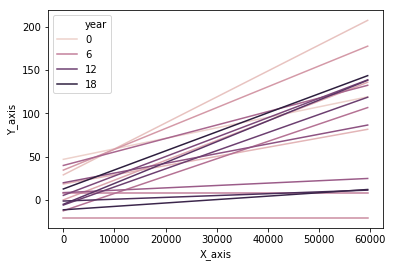

In [57]:
sns.lineplot(data=prices_df, x='X_axis', y='Y_axis', hue="year")

Multiple runs

In [114]:
path = "/Users/b1017579/Documents/PhD/Projects/10. ELECSIM/run/best_run_beis_comparison/best_run/best_run_beis_comparison"
all_files = glob.glob(path + "/*.csv")
results = []

for filename in all_files:
#     print(filename)
    result = pd.read_csv(filename, index_col=None, header=0)
    per_year_dat = get_projection_difference_sum(result)
    per_year_dat = per_year_dat.rename({'actual_perc':"beis_projections"}, axis=1)
    per_year_long = per_year_dat.drop(['value_actual', 'value_predicted'], axis=1).reset_index().melt(['year','fuel_type'])
#     sns.lineplot(data=per_year_long, x='year', hue='fuel_type', style='variable', y='value')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()
#     plt.close()
    results.append(per_year_long)
print(len(results))


25


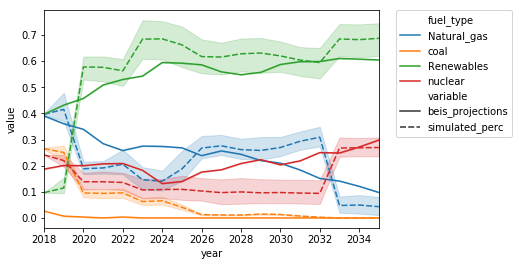

In [113]:
one_df = pd.concat(results)
sns.lineplot(data=one_df, x='year', hue='fuel_type', style='variable', y='value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([2018,2035])
plt.show()
plt.close()
